### 通し課題1 Kickstar Ploject

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import precision_recall_fscore_support
import datetime
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import cufflinks as cf

In [2]:
df_ks0 = pd.read_csv("kickstarter-projects/ks-projects-201801.csv")
df_ks0.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [3]:
#必要そうな列だけcsv読み込む
df_ks = pd.read_csv("kickstarter-projects/ks-projects-201801.csv")[[ 'state', 'category', 'main_category', 'currency', 'country', 'usd pledged', 'usd_goal_real', 'deadline', 'launched']]

#KSのlaunched、deadlineから開催期間(日数)を計算する
#文字列をdatetime型に変換
#df_ks['launched'] = datetime.datetime.strptime(df_ks['launched'], '%Y/%m/%d %H:%M') 
#df_ks['deadline'] = datetime.datetime.strptime(df_ks['deadline'], '%Y/%m/%d')
df_ks['launched'] = pd.to_datetime(df_ks['launched']) 
df_ks['deadline'] = pd.to_datetime(df_ks['deadline'])

#期間を計算
df_ks['delta'] = (df_ks['deadline'] - df_ks['launched']).apply(lambda x: x.days)
#こっちだとエラー出た
#df_ks['delta'] = datetime.datetime.strptime(df_ks['launched'], '%d %H:%M:%S')
#.apply(~がないとerror起こす。配列には適用できない？
#print(df_ks['delta'].days)

#launch, deadline削除
df_ks = df_ks.drop(columns=['launched', 'deadline'])
#stateがsuccessfulとfailed以外のもの削除
df_ks = df_ks.query('state == ["successful", "failed"]')

#stateの列を数字に置き換え(failedを0、successfulを1)
for df in [df_ks]:    
    df.loc[df['state']=='failed', "state"]=0
    df.loc[df['state']=='successful', "state"]=1

print(df_ks.head())
#欠損値がないか確認
print(df_ks.isnull().sum())
print(df_ks.notnull().sum())

   state        category main_category currency country  usd pledged  \
0      0          Poetry    Publishing      GBP      GB          0.0   
1      0  Narrative Film  Film & Video      USD      US        100.0   
2      0  Narrative Film  Film & Video      USD      US        220.0   
3      0           Music         Music      USD      US          1.0   
5      1     Restaurants          Food      USD      US      52375.0   

   usd_goal_real  delta  
0        1533.95     58  
1       30000.00     59  
2       45000.00     44  
3        5000.00     29  
5       50000.00     34  
state              0
category           0
main_category      0
currency           0
country            0
usd pledged      210
usd_goal_real      0
delta              0
dtype: int64
state            331675
category         331675
main_category    331675
currency         331675
country          331675
usd pledged      331465
usd_goal_real    331675
delta            331675
dtype: int64


In [4]:
#usd pledged の欠損値を埋める
df_ks['usd pledged'] = df_ks['usd pledged'].fillna("0")

   state        category main_category currency country usd pledged  \
0      0          Poetry    Publishing      GBP      GB           0   
1      0  Narrative Film  Film & Video      USD      US         100   
2      0  Narrative Film  Film & Video      USD      US         220   
3      0           Music         Music      USD      US           1   
5      1     Restaurants          Food      USD      US       52375   

   usd_goal_real  delta  goal_band  
0        1533.95     58          0  
1       30000.00     59          5  
2       45000.00     44          5  
3        5000.00     29          1  
5       50000.00     34          5  


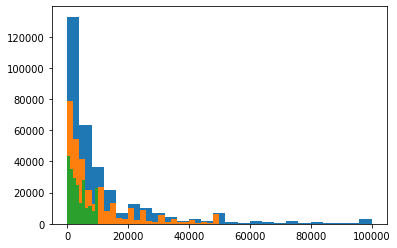

In [5]:
#とりあえず定量的な値はusd pledged,goalとdeltaだけなのでこれらを使う。
#goalの分布
data = df_ks['usd_goal_real']
plt.hist(data, range=(0, 100000), bins=25);
plt.hist(data, range=(0, 50000), bins=25);
plt.hist(data, range=(0, 10000), bins=10);

#goalを金額で7つに分類
for df in [df_ks]:
    df['goal_band'] = pd.cut(df.usd_goal_real, [0, 2500, 5000, 7500, 10000, 20000, 50000, 1000000000000], labels=False)

print(df_ks.head())

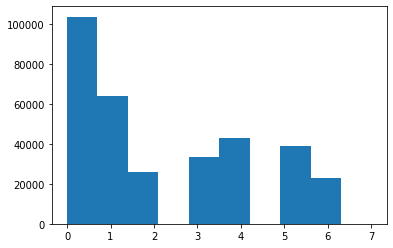

In [6]:
plt.hist(df_ks['goal_band'], range=(0, 7), bins=10);

In [7]:
df_ks.head()

,state,category,main_category,currency,country,usd pledged,usd_goal_real,delta,goal_band
0,0,Poetry,Publishing,GBP,GB,0,1533.95,58,0
1,0,Narrative Film,Film & Video,USD,US,100,30000.00,59,5
2,0,Narrative Film,Film & Video,USD,US,220,45000.00,44,5
3,0,Music,Music,USD,US,1,5000.00,29,1
5,1,Restaurants,Food,USD,US,52375,50000.00,34,5


In [8]:
print(df_ks.describe())

               state  usd_goal_real          delta      goal_band
count  331675.000000   3.316750e+05  331675.000000  331675.000000
mean        0.403877   4.151000e+04      32.954902       2.167501
std         0.490674   1.108930e+06      12.713329       2.047758
min         0.000000   1.000000e-02       0.000000       0.000000
25%         0.000000   2.000000e+03      29.000000       0.000000
50%         0.000000   5.000000e+03      29.000000       1.000000
75%         1.000000   1.500000e+04      35.000000       4.000000
max         1.000000   1.663614e+08      91.000000       6.000000


In [9]:
#説明変数を3つに絞ってロジスティック回帰
y = df_ks["state"].values
X = df_ks[["usd pledged","goal_band", "delta"]].values
clf = SGDClassifier(loss='log', penalty='none', max_iter=100000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X, y)

# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
print("w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}".format(w0, w1, w2))


w0 = 443.225, w1 = 31.967, w2 = -25819.412


In [10]:
# ラベルを予測
y_pred = clf.predict(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_pred)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_pred)))

対数尤度 = -5.074
正答率 = 85.308%


In [11]:
# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# カテゴリ「」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

正答率（Accuracy） = 85.308%
適合率（Precision） = 83.321%
再現率（Recall） = 94.214%
F1値（F1-score） = 88.433%


In [12]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y, y_pred), 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])
conf_mat

,予測 = failed,予測 = successful
正解 = failed,186278,11441
正解 = successful,37289,96667


In [13]:
#Day2
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.metrics import mean_absolute_error # 回帰問題における性能評価に関する関数

In [14]:
#　ホールドアウト法
# 全データのうち、何%をテストデータにするか（今回は20%に設定
test_size = 0.3      
# ホールドアウト法を実行（テストデータはランダム選択）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

In [15]:
# 学習用データを使ってロジスティック回帰モデルを学習
clf2 = SGDClassifier(loss='log', penalty='none', max_iter=100000, fit_intercept=True, random_state=1234, tol=1e-3)
clf2.fit(X_train, y_train)

# 重みを取得して表示
w0 = clf2.intercept_[0]
w1 = clf2.coef_[0, 0]
w2 = clf2.coef_[0, 1]
print("w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}".format(w0, w1, w2))

# 学習用データに対する予測を実行
y_pred_train = clf2.predict(X_train)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_train, y_pred_train)))

# 正答率を計算
accuracy =  accuracy_score(y_train, y_pred_train)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, y_pred_train)

# カテゴリ「2000万以上」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

w0 = 420.047, w1 = 66.366, w2 = -26173.264
対数尤度 = -4.998
正答率（Accuracy） = 85.528%
適合率（Precision） = 90.436%
再現率（Recall） = 84.653%
F1値（F1-score） = 87.449%


In [23]:
# 交差検証法
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_logloss = 0
cross_valid_accuracy = 0
cross_valid_precision = 0
cross_valid_recall = 0
cross_valid_f1_score = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    # 学習用データを使ってロジスティック回帰モデルを学習
    clf2 = SGDClassifier(loss='log', penalty='none', max_iter=100000, fit_intercept=True, random_state=1234, tol=1e-3)
    clf2.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = clf2.predict(X_test)
    
    # 対数尤度を表示
    logloss = - log_loss(y_test, y_pred_test)
    print("Fold %s"%split_num)
    print('対数尤度 = {:.3f}'.format(logloss))

    # 正答率を計算
    accuracy =  accuracy_score(y_test, y_pred_test)
    print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

    # Precision, Recall, F1-scoreを計算
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_test)

    
    #後で平均を取るために加算
    cross_valid_logloss += logloss
    cross_valid_accuracy += accuracy 
    cross_valid_precision += precision 
    cross_valid_recall += recall 
    cross_valid_f1_score += f1_score 
    split_num += 1

# 平均値を最終的な汎化誤差値とする
final_logloss = cross_valid_logloss / n_split
final_accuracy = cross_valid_accuracy / n_split
final_precision = cross_valid_precision / n_split
final_recall = cross_valid_recall / n_split
final_f1_score = cross_valid_f1_score / n_split
print('対数尤度 = {:.3f}'.format(final_logloss))
print('正答率（Accuracy） = {:.3f}%'.format(100 * final_accuracy))
print('適合率（Precision） = {:.3f}%'.format(100 * final_precision))
print('再現率（Recall） = {:.3f}%'.format(100 * final_recall))
print('F1値（F1-score） = {:.3f}%'.format(100 * final_f1_score))

Fold 1
対数尤度 = -4.210
正答率（Accuracy） = 87.812%
Fold 2
対数尤度 = -3.902
正答率（Accuracy） = 88.703%
Fold 3
対数尤度 = -3.499
正答率（Accuracy） = 89.870%
Fold 4
対数尤度 = -4.547
正答率（Accuracy） = 86.835%
Fold 5
対数尤度 = -4.467
正答率（Accuracy） = 87.067%
対数尤度 = -4.125
正答率（Accuracy） = 88.057%


TypeError: unsupported format string passed to numpy.ndarray.__format__

numpy.float64